<a href="https://colab.research.google.com/github/fneaplle/ML/blob/Electric/CNN_Shuffle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import session
'''

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Colab Notebooks/PL/Data/100average_interpol.csv'

df = pd.read_csv(path, index_col='Datetime', parse_dates=True, encoding='cp949')
df = df[:30000]

df['time'] = df.index
df.reset_index(inplace=True, drop=True)

date_time = df['time']
df = df.drop(['time'], axis=1)
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [4]:
q1, q3 = np.percentile(df['FRWR_ACT_QTY'].values, [25, 75])
iqr = q3 - q1
lower_bound=q1-(iqr*1.5)
upper_bound=q3+(iqr*1.5)

In [5]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

'''
이상치(outlier 제거)
'''
df["FRWR_ACT_QTY"] = df["FRWR_ACT_QTY"].apply(lambda x: lower_bound if x<lower_bound else x)
df["FRWR_ACT_QTY"] = df["FRWR_ACT_QTY"].apply(lambda x: upper_bound if x>upper_bound else x)

#Data Split
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

{'boxes': [<matplotlib.lines.Line2D at 0x7f60f204a470>],
 'caps': [<matplotlib.lines.Line2D at 0x7f60f204ae80>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f60f1fe0940>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f60f1fe05c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f60f204a780>,
  <matplotlib.lines.Line2D at 0x7f60f204ab00>]}

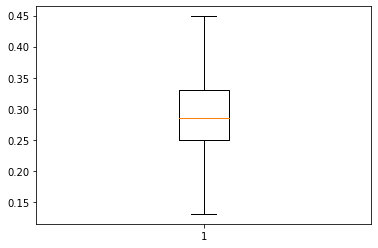

In [6]:
plt.boxplot(df['FRWR_ACT_QTY'])

In [7]:
input_length=1*24 #168
target_length=1*24 #24
num_features=5
BATCH_SIZE=32

In [33]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

In [ ]:
w = WindowGenerator(input_width=24, label_width=24, shift=24)

for inp, tar in w.train:
  print(inp.shape)
  print(tar.shape)

In [34]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.layer1=tf.keras.layers.Conv1D(32, kernel_size=3,
                                           padding='same',
                                           activation='relu')
        self.pool1=tf.keras.layers.MaxPool1D(pool_size=3, strides=1, padding='same')

        self.layer2=tf.keras.layers.Conv1D(64, kernel_size=6,
                                           padding='same',
                                           activation='relu')
        self.pool2=tf.keras.layers.MaxPool1D(pool_size=6, strides=1, padding='same')

        self.layer3=tf.keras.layers.Conv1D(128,kernel_size=input_length - target_length + 1,
                                           padding='same',
                                           activation='relu')
        self.pool3=tf.keras.layers.MaxPool1D(pool_size=input_length - target_length + 1, strides=1, padding='same')

        self.Flatten=tf.keras.layers.Flatten()
        self.layer4=tf.keras.layers.Dense(target_length*num_features)
        self.Reshape=tf.keras.layers.Reshape((target_length, num_features))
        self.layer5=tf.keras.layers.Dense(5)

    def call(self, inp,trainable=False):        
      x=self.layer1(inp)
      x=self.pool1(x)

      x=self.layer2(x)
      x=self.pool2(x)

      x=self.layer3(x)
      x=self.pool3(x)

      #x=self.Flatten(x)
      #x=self.layer4(x)
      #x=self.Reshape(x)
      x=self.layer5(x)
      return x
    
model=MLP()

In [43]:
loss_object=tf.keras.losses.MSE
acc_object=tf.keras.losses.MAE

mae_object=tf.keras.losses.MAE
rmse_object=tf.keras.metrics.RootMeanSquaredError()
mse_object=tf.keras.metrics.MeanSquaredError()
msle_object=tf.keras.metrics.MeanSquaredLogarithmicError()
mape_object=tf.keras.metrics.MeanAbsolutePercentageError()

train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy=tf.keras.metrics.Mean(name='train_accuracy')
test_mape=tf.keras.metrics.Mean(name='test_mape')
val_loss=tf.keras.metrics.Mean(name='val_loss')

In [44]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [25]:
X=tf.random.normal((32,24,5))
tf.math.reduce_mean(X)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010812536>

In [45]:
def custom_loss(y_true, y_pred):
  '''
  Args:
  y_pred: pred
  y: true
  '''

  loss=tf.abs(y_true-y_pred)
  loss=loss*np.array([1.,0.,0.,0.,0.])

  return tf.math.reduce_mean(loss)

In [46]:
'''
Hyper parameter in Training Steps
'''

Patience=5

In [51]:
#batch_generator(data, input_width, label_width, shift, label_columns):
train_loss_list=[]
val_loss_list=[]

num_epochs = 100

validation_min=99999 #Magic_number
early_stop_count=0

for epoch in range(num_epochs):
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    
    print(f'epoch:{epoch}')
    for inp, tar in w.train:        
        with tf.GradientTape() as t:
            pred=model(inp)
            loss_value=custom_loss(y_true=tar, y_pred=pred)
            
        grads=t.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        acc_value=acc_object(pred, tar)
        
        train_loss(loss_value)
        train_accuracy(acc_value)

    train_loss_list.append(train_loss.result().numpy())
    
    for inp_val, tar_val in w.val:
        pred_val=model(inp_val)
        loss_value_val=custom_loss(y_pred=pred_val, y_true=tar_val)
        val_loss(loss_value_val)
    val_loss_list.append(val_loss.result().numpy())
    
    print(f'train_loss:{train_loss.result().numpy()}, train_accuracy:{train_accuracy.result().numpy()}')
    print(f'validation_loss:{val_loss.result().numpy()}')

    '''
    early_stop_session
    '''
    if validation_min > loss_value_val:
      early_stop_count=0
      validation_min=loss_value_val
    else:
      if early_stop_count>Patience:
        print('early_stop!!!!')
        break
      else:
        early_stop_count+=1

epoch:0
train_loss:0.048144713044166565, train_accuracy:0.8066350817680359
validation_loss:0.11549770087003708
epoch:1
train_loss:0.0464380644261837, train_accuracy:0.809987485408783
validation_loss:0.10765118151903152
epoch:2
train_loss:0.0454600490629673, train_accuracy:0.8144485950469971
validation_loss:0.11401867866516113
epoch:3
train_loss:0.04476992040872574, train_accuracy:0.8180825710296631
validation_loss:0.11227983981370926
epoch:4
train_loss:0.04417051374912262, train_accuracy:0.8190653920173645
validation_loss:0.11893673986196518
epoch:5
train_loss:0.04378141835331917, train_accuracy:0.8188381791114807
validation_loss:0.1239500418305397
epoch:6
train_loss:0.04338955879211426, train_accuracy:0.8195969462394714
validation_loss:0.12283314019441605
epoch:7
train_loss:0.043063681572675705, train_accuracy:0.8196499347686768
validation_loss:0.12342657893896103
epoch:8
train_loss:0.04282146692276001, train_accuracy:0.818543016910553
validation_loss:0.12917371094226837
epoch:9
train

In [ ]:
#save model
model.save_weights('./CNN-normal.ckpt')

In [ ]:
#load model
model.load_weights('./CNN-normal.ckpt')

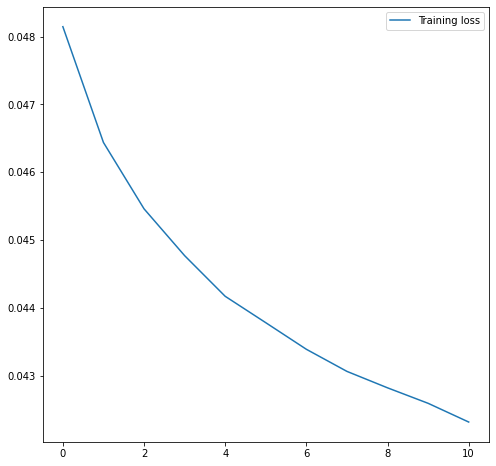

In [52]:
#train loss graph
plt.figure(figsize=(8,8))
plt.plot(range(len(train_loss_list)), train_loss_list, label='Training loss')
#plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation loss') 
plt.legend(loc='upper right')

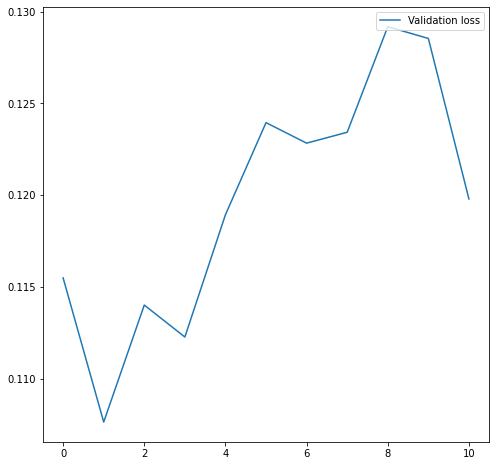

In [53]:
#validation loss graph
plt.figure(figsize=(8,8))
#plt.plot(range(num_epochs)[10:], train_loss_list[10:], label='Training loss')
plt.plot(range(len(val_loss_list)), val_loss_list, label='Validation loss')
plt.legend(loc='upper right')

In [54]:
def tensorflow_quantile_loss(y, y_pred, quantile):
  """Computes quantile loss for tensorflow.
  Standard quantile loss as defined in the "Training Procedure" section of
  the main TFT paper
  Args:
    y: Targets
    y_pred: Predictions
    quantile: Quantile to use for loss calculations (between 0 & 1)
  Returns:
    Tensor for quantile loss.
  """

  # Checks quantile
  if quantile < 0 or quantile > 1:
    raise ValueError(
        'Illegal quantile value={}! Values should be between 0 and 1.'.format(
            quantile))

  prediction_underflow = y - y_pred
  q_loss = quantile * tf.maximum(prediction_underflow, 0.) + (
      1. - quantile) * tf.maximum(-prediction_underflow, 0.)

  return tf.reduce_sum(q_loss, axis=-1)

In [57]:
#Model Performance
#MSE/RMSE/MSLE/R2/MAPE
from sklearn.metrics import r2_score

mean=train_mean['FRWR_ACT_QTY']
std=mean=train_std['FRWR_ACT_QTY']

r2=tf.metrics.Mean()
r2.reset_states()
mae=tf.keras.metrics.Mean()
mae.reset_states()
rmse_object.reset_states()
mse_object.reset_states()
msle_object.reset_states()
mape_object.reset_states()
quantile_metrics=tf.keras.metrics.Mean()

for inp, tar in w.test:
    pred=model(inp)[:,:,0]
    tar=tar[:,:,0]
    
    r2(r2_score(y_true=tar, y_pred=pred, multioutput='variance_weighted'))
    mae(mae_object(y_true=tar, y_pred=pred))
    rmse_object(y_true=tar, y_pred=pred)
    mse_object(y_true=tar, y_pred=pred)
    msle_object(y_true=tar, y_pred=pred)
    mape_object(y_true=tar, y_pred=pred)
    quantile_metrics(tensorflow_quantile_loss(y=tar, y_pred=pred, quantile=0.5))
    #print(f'quantile_loss : {quantile_loss(tar,pred,0.5)}')

print(f'Model R2: {r2.result().numpy()}')
print(f'Model MAE: {mae.result().numpy()}')
print(f'Model RMSE: {rmse_object.result().numpy()}')
print(f'Model MSE: {mse_object.result().numpy()}')
print(f'Model MSLE: {msle_object.result().numpy()}')
print(f'Model Quantile(0.5): {quantile_metrics.result().numpy()}')
print(f'Model MAPE: {mape_object.result().numpy()}%')

Model R2: 0.552507758140564
Model MAE: 0.5836843848228455
Model RMSE: 0.7843286395072937
Model MSE: 0.6151714324951172
Model MSLE: 0.09576917439699173
Model Quantile(0.5): 7.004213809967041
Model MAPE: 361.8407897949219%


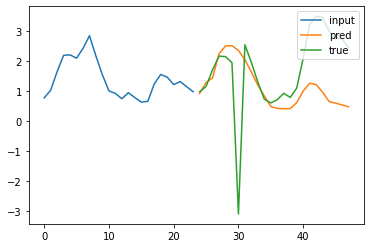

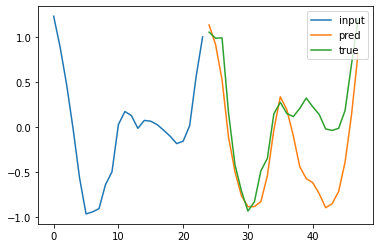

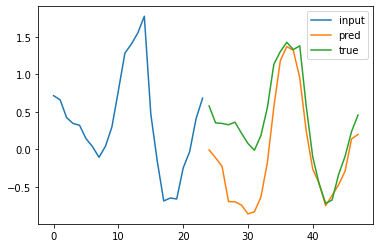

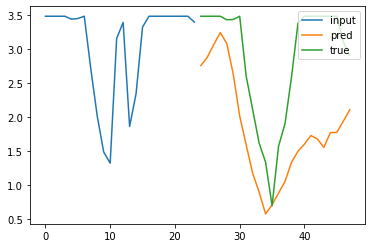

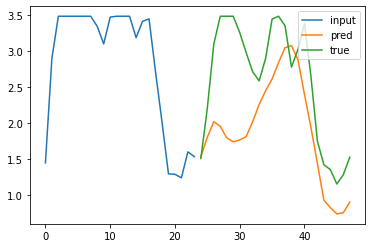

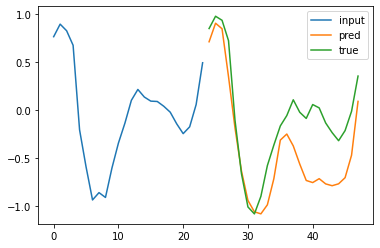

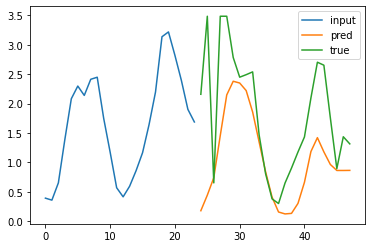

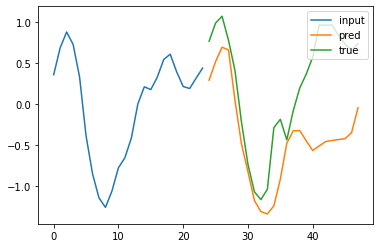

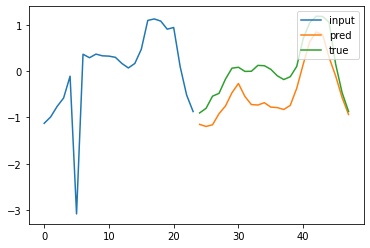

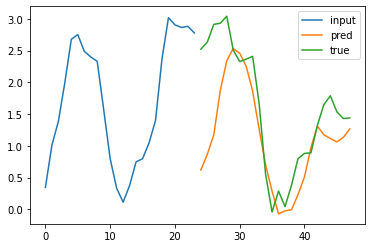

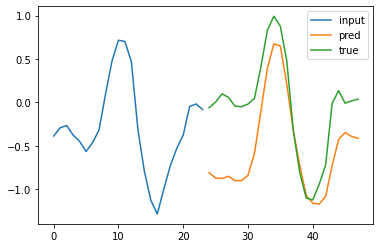

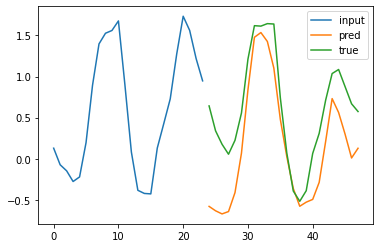

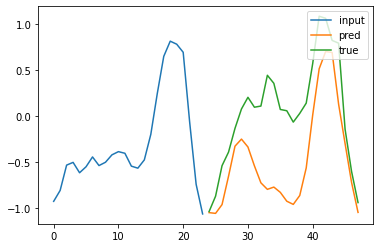

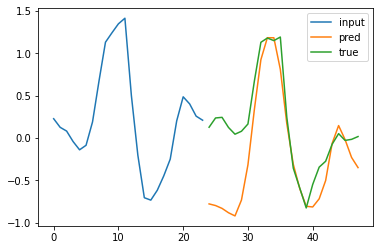

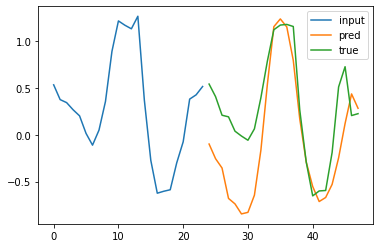

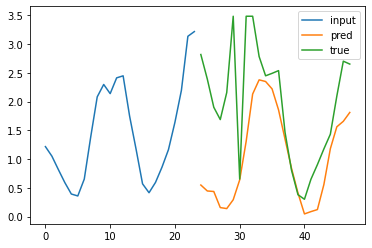

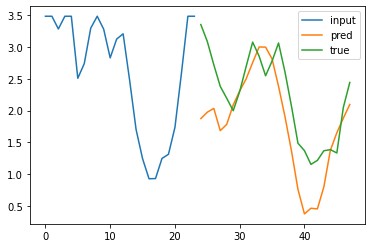

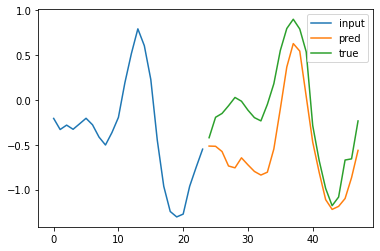

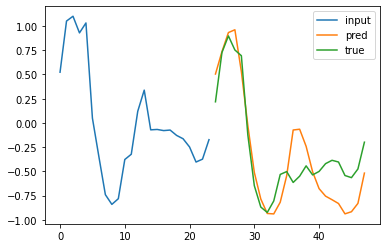

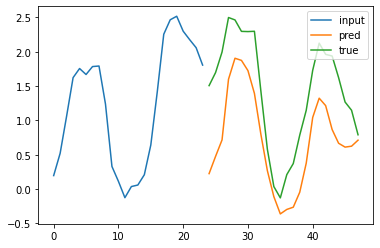

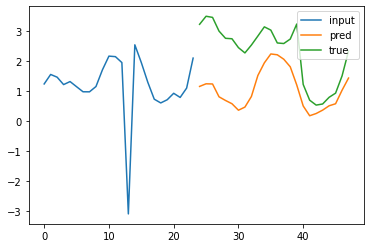

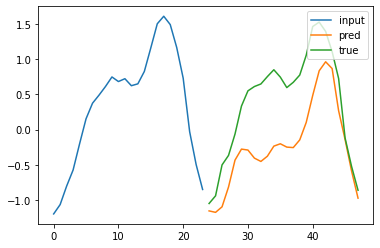

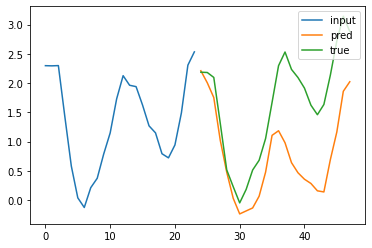

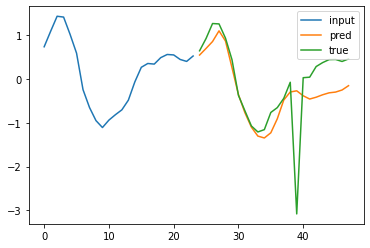

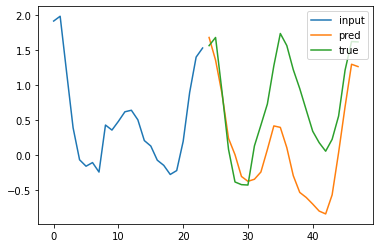

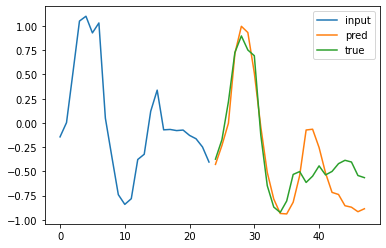

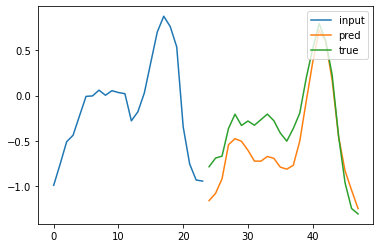

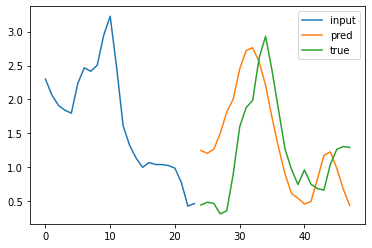

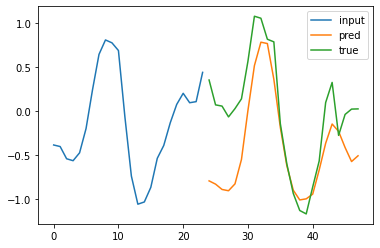

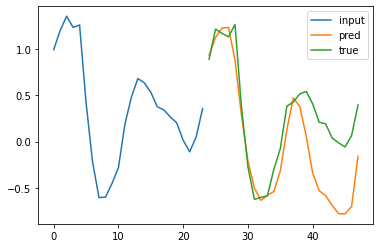

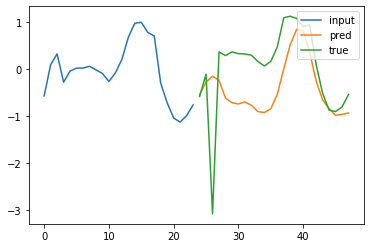

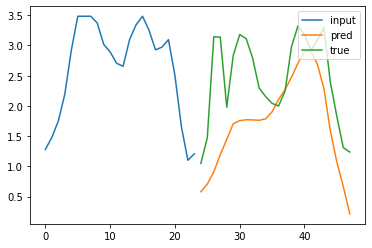

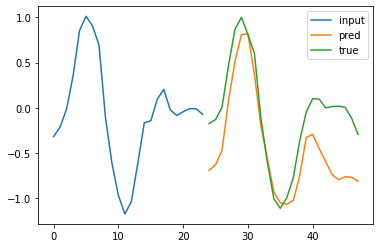

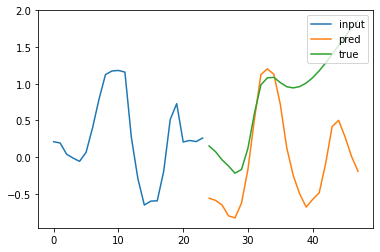

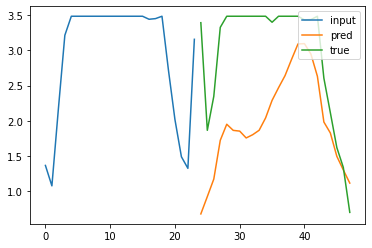

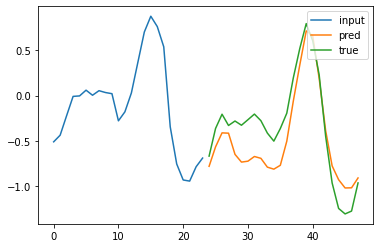

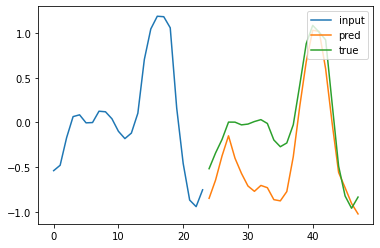

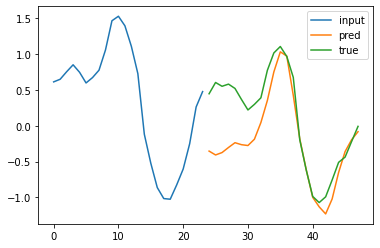

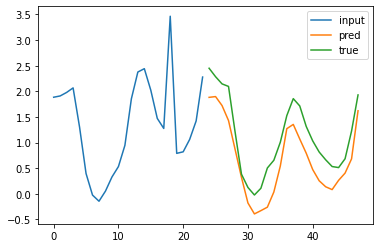

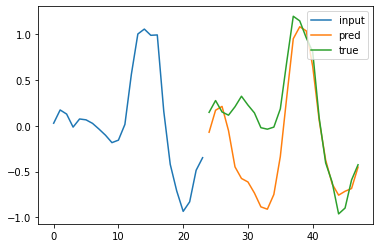

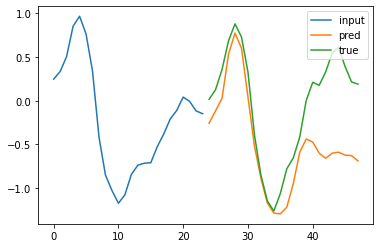

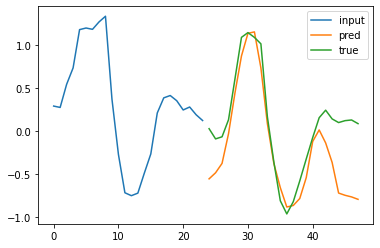

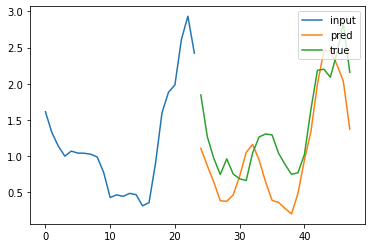

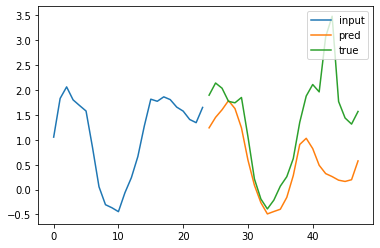

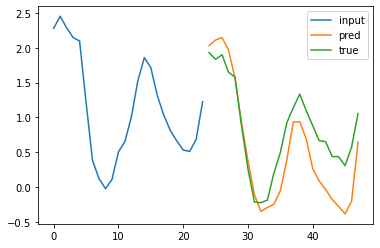

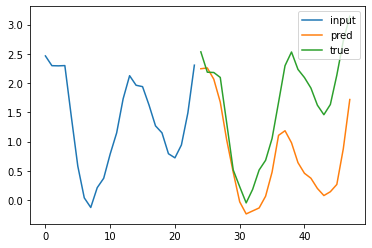

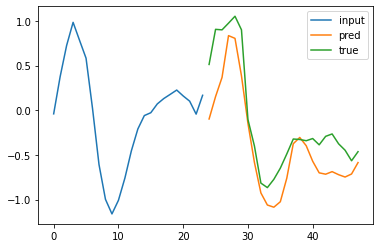

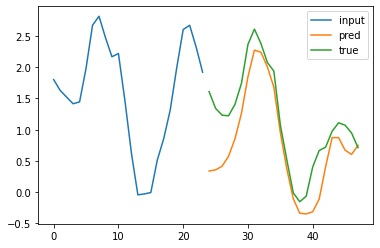

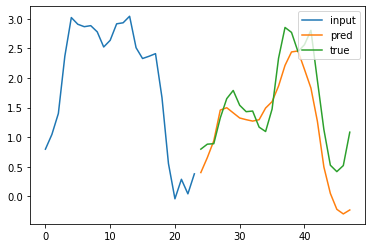

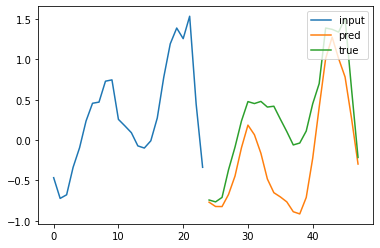

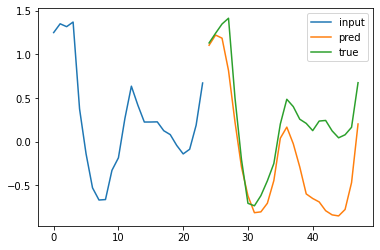

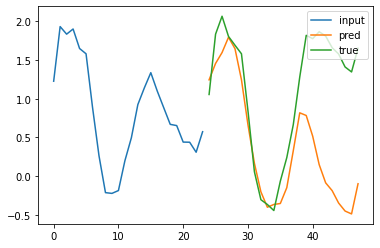

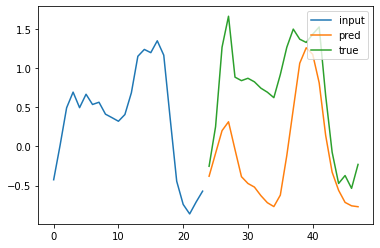

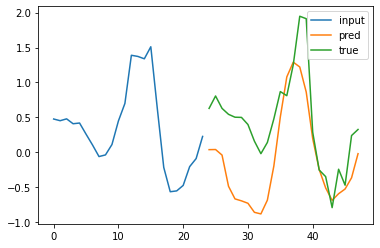

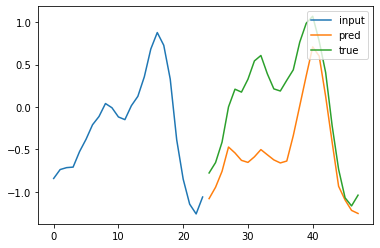

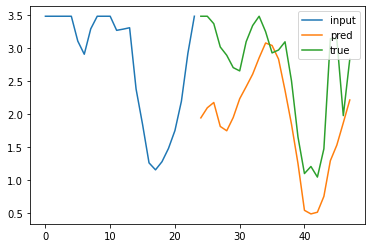

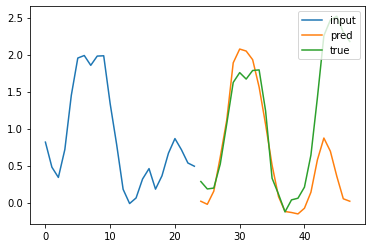

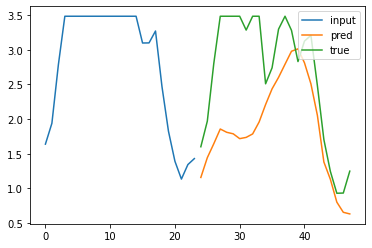

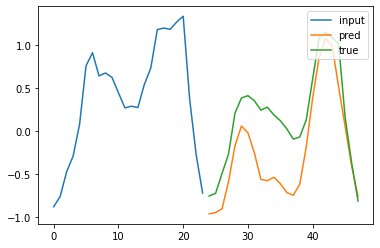

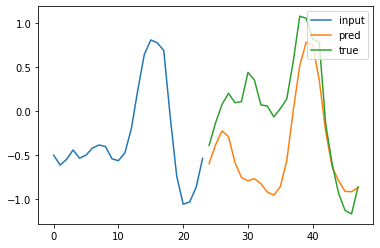

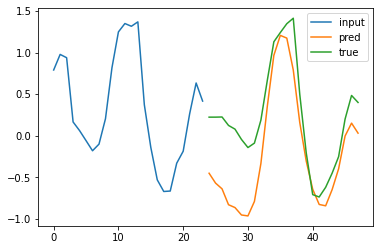

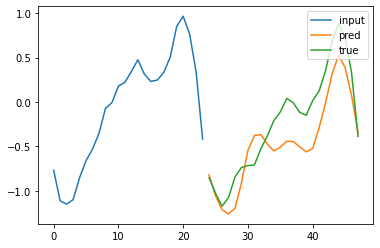

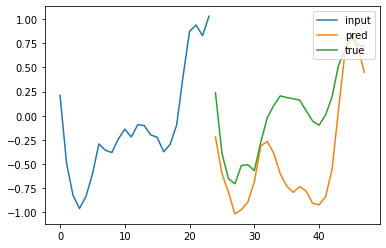

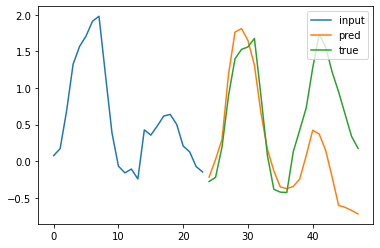

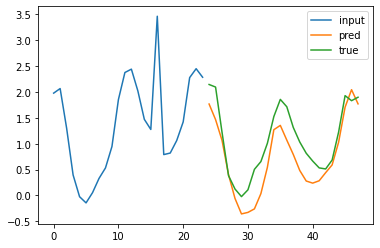

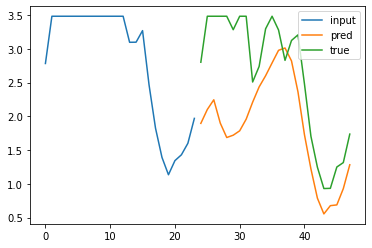

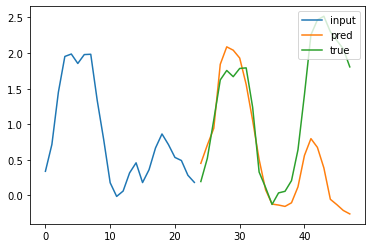

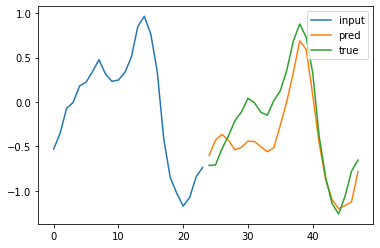

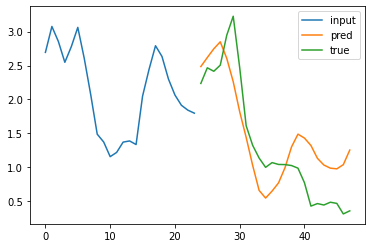

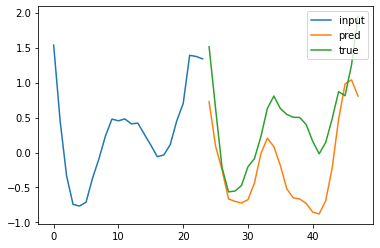

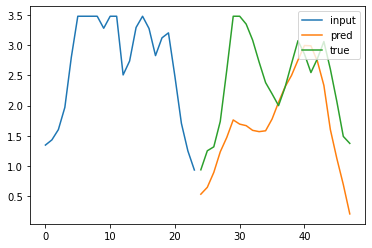

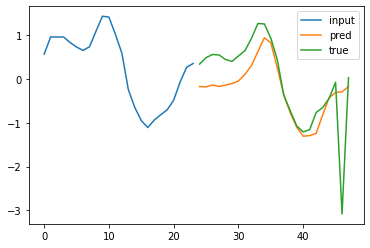

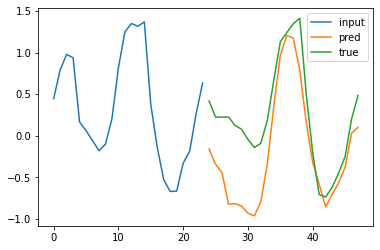

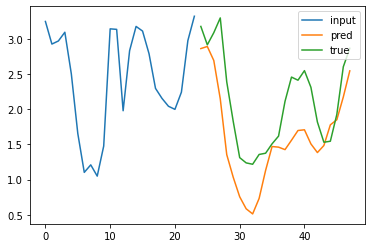

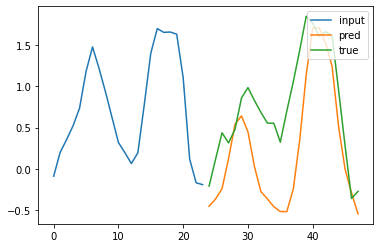

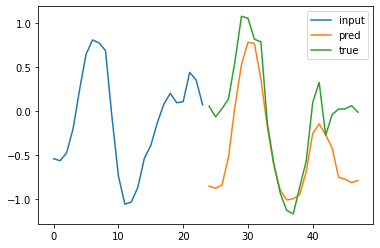

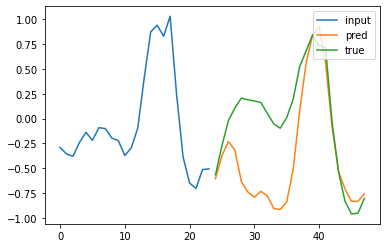

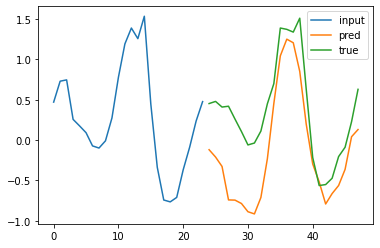

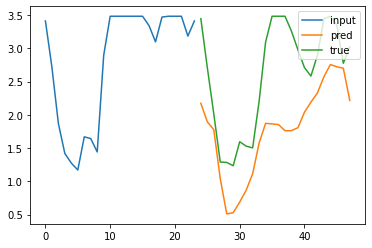

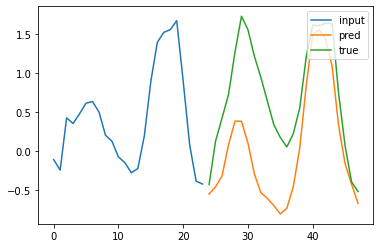

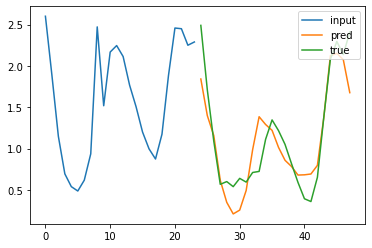

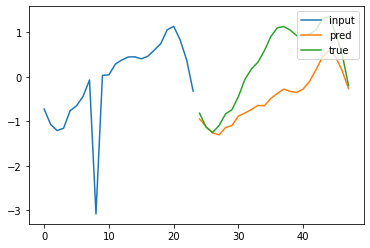

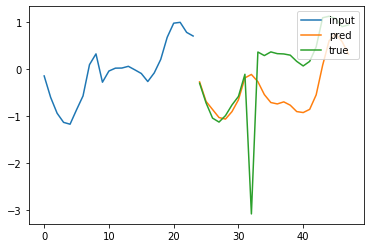

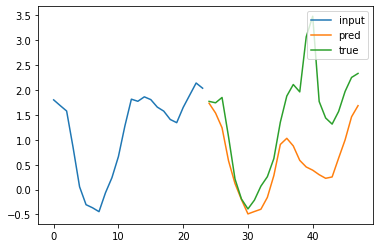

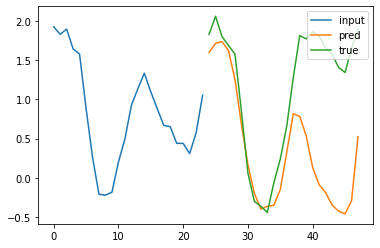

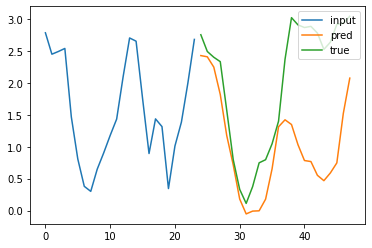

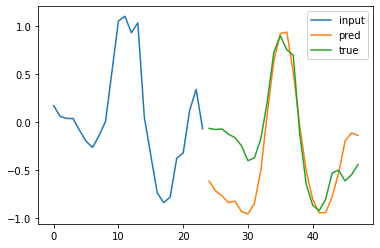

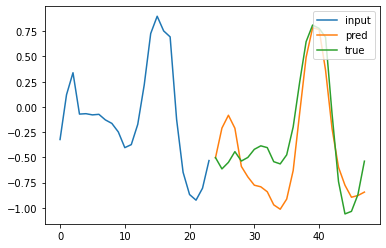

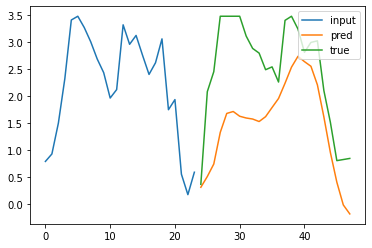

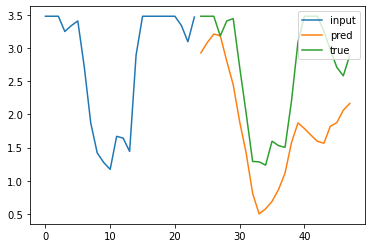

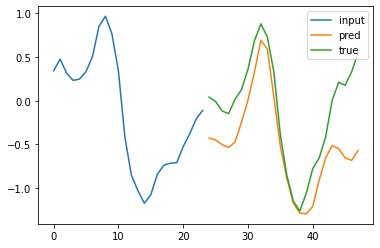

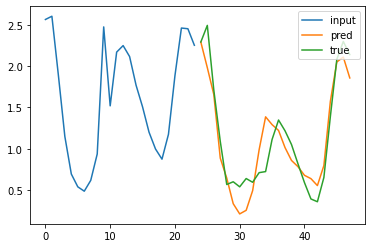

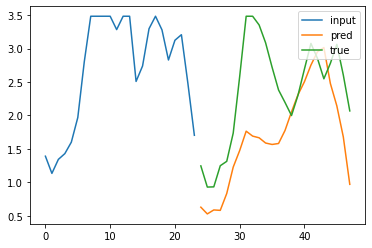

In [59]:
#Plotting

for inp, tar in w.test:
    pred=model(inp)
    
    inp_indices=np.arange(48)[slice(0,24)]
    out_indices=np.arange(48)[slice(24,48)]

    plt.plot(inp_indices, inp[0][:, 0], label='input')
    plt.plot(out_indices, pred[0][:,0], label='pred')
    plt.plot(out_indices, tar[0][:,0], label='true')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
#Plotting

for inp, tar in batch_generator(test_df, 24, 24, 24, test_df.columns):
    #pred=model(inp)[:,:,0]
    #tar=tar[:,:,0]

    pred=model(inp)
    r=r2_score(y_true=tar[:,:,0], y_pred=pred[:,:,0], multioutput='variance_weighted')

    if r < 0:
      print(f'r^2 : {r}')
      plt.plot(range(24), pred[0][:,0], label='pred')
      plt.plot(range(24), tar[0][:,0], label='true')
      plt.legend(loc='upper right')
      plt.show()

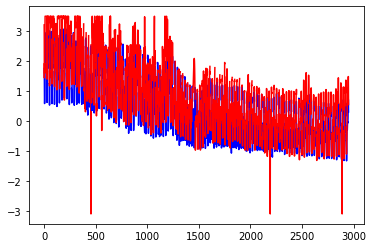

In [60]:
#test=test_df[0:48].values
#test=test[np.newaxis,:,:]

#pred = model(test[:,:24,:5])
#true = test[0,24:,0]

#plt.plot(pred[0,:,0])
#plt.plot(true)
#plt.show()

for i in range(0,3000-48,24):
  data=test_df[i:i+48]
  inp=data[:24].values
  true=data[24:].values

  pred=model(inp[np.newaxis,:,:])
  pred=pred[0,:,0]
  true=true[:,0]
  
  plt.plot(np.arange(3000)[slice(i,i+24)], pred, label='pred', color='blue')
  plt.plot(np.arange(3000)[slice(i,i+24)], true, label='true', color='red')
  
#plt.legend()
plt.show()